# Code to plot spatial trends in the linked GTR-CH data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Python tools
from matplotlib import pyplot as plt
import pandas as pd
import math
import numpy as np
from collections import defaultdict
from functools import partial

# Geometry, shapefiles and projections
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import pyproj
from descartes import PolygonPatch
from shapely.ops import transform

# Local imports
import plotplot as pp

## Prepare functions and data for matching

In [2]:
# Shape files for TTWAs, GB and NI
shp_filename = '/Users/jklinger/Downloads/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom.shp'
gb_filename = '/Users/jklinger/Downloads/Countries_December_2016_Ultra_Generalised_Clipped_Boundaries_in_Great_Britain/Countries_December_2016_Ultra_Generalised_Clipped_Boundaries_in_Great_Britain.shp'
ni_filename = '/Users/jklinger/Downloads/OSNI_Open_Data_Largescale_Boundaries__Country_2016/OSNI_Open_Data_Largescale_Boundaries__Country_2016.shp'

In [3]:
# Generate a function to create a UK East/North point from Lon/Lat
wgs84 = pyproj.Proj(init = 'epsg:4326')
ukgrid = pyproj.Proj(init = 'epsg:27700')
EnPoint = lambda lon, lat : Point(*pyproj.transform(wgs84, ukgrid, lon, lat))

In [4]:
# Calculate great circle distance between lat/lon points
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [5]:
# Convert lat/lon to east/north
def get_en(row, extra=""):
    try:
        return pyproj.transform(wgs84, ukgrid, row[extra+'lon'], row[extra+'lat'])
    except:
        pass

# Read plotting data
plottable_df = pd.read_json('gtr_academic_private.json')
plottable_df["distance"] = plottable_df.apply(lambda row: haversine(row['lon'],row['lat'],
                                                                     row['plon'],row['plat']), axis=1)

# Generate the east/northings for unis / private sector
lat_lons = plottable_df.apply(get_en, axis=1) # Unis
plat_lons = plottable_df.apply(get_en, axis=1, extra="p") # Private sector

lons = [x for x,y in [X for X in lat_lons if X is not None]] # Unis
lats = [y for x,y in [X for X in lat_lons if X is not None]] # Unis
plons = [x for x,y in plat_lons] # Private sector 
plats = [y for x,y in plat_lons] # Private sector 

## Map universities to TTWAs, and also calculate the distance between collaborations

In [6]:
ttwa_cats = {} # TTWA id -> CE label -> count
data = defaultdict(list) # TTWA id -> [distances]
id_name_mapping = {} # TTWA id -> TTWA name

# Open TTWA shapes
with fiona.open(shp_filename) as ttwas:
    # Iterate through ttwas
    for ttwa in ttwas:
        id_ = ttwa['id'] # TTWA id
        id_name_mapping[id_] = ttwa['properties']['ttwa11nm'] # Assign name to TTWA
        if id_ not in ttwa_cats:
            ttwa_cats[id_] = {}
        # Iterate through table looking for lat/lon points in TTWA
        for _,row in plottable_df.iterrows():
            lat = row['lat']
            lon = row['lon']
            try:
                point = EnPoint(lon,lat)
            except:
                continue
            if not point.within(shape(ttwa['geometry'])):
                continue
            # Fill data if point is in polygon
            cat = row['ce_label']
            if cat not in ttwa_cats[id_]:
                ttwa_cats[id_][cat] = 0
            ttwa_cats[id_][cat] += 1
            distance = row['distance']
            data[id_].append(distance)            

## Plot TTWAs coloured by median distance, with private company positions overlaid

524.050862479


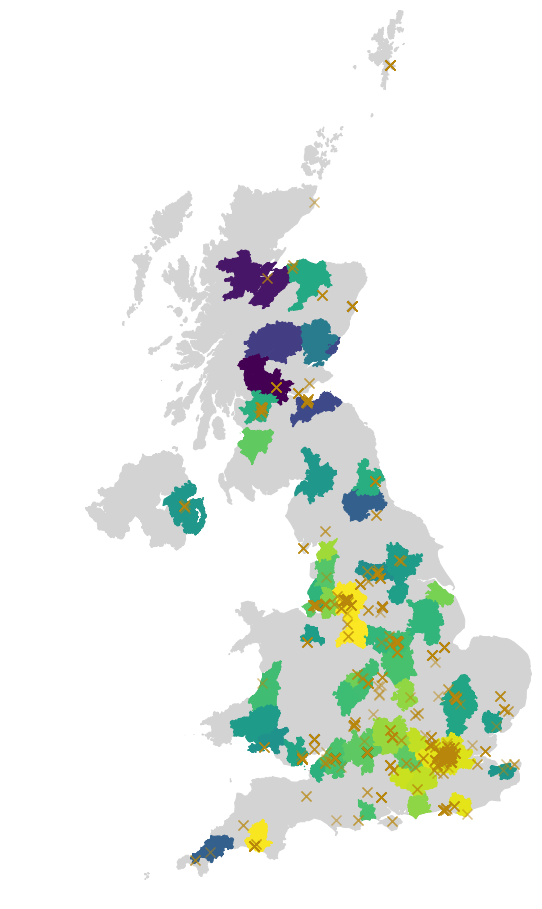

In [111]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:29902'), # source coordinate system
    pyproj.Proj(init='epsg:27700')) # destination coordinate system

def draw(data,lons,lats,max_distance=0):
    cmap = plt.get_cmap("viridis_r")
    fig, ax = plt.subplots(figsize=(8,16))

    # Lists of x,y bounds in order to set fig-ax lims
    xs = []
    ys = []
    # Plot GB
    with fiona.open(gb_filename) as gb:
        for country in gb:
            s = shape(country['geometry'])
            p = PolygonPatch(s, color="lightgrey")
            ax.add_patch(p)
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]

    # Plot NI, correcting for different east/northing zone
    with fiona.open(ni_filename) as ni:
         for country in ni:
            pyproj.Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
            s = shape(country['geometry'])
            s = transform(project, s)
            p = PolygonPatch(s, color="lightgrey")
            ax.add_patch(p)
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]

    # Overlay TTWAS, if non zero distances
    with fiona.open(shp_filename) as ttwas:
        # Calculate the max distance
        if max_distance == 0:
            for ttwa in ttwas:
                if data[ttwa['id']] == []:
                    continue
                distance = np.median(data[ttwa['id']])
                if max_distance < distance:
                    max_distance = distance
        # Plot TTWAs with colour
        for ttwa in ttwas:
            id_ = ttwa['id']
            if data[id_] == []:
                continue
            distance = np.median(data[id_])
            s = shape(ttwa['geometry'])
            p = PolygonPatch(s, color=cmap(distance/max_distance))
            xs += [s.bounds[0],s.bounds[2]]
            ys += [s.bounds[1],s.bounds[3]]
            ax.add_patch(p)
    # Set bounds
    ax.set_xlim(min(xs),max(xs))
    ax.set_ylim(min(ys),max(ys))
    # Scatter data
    ax.scatter(x=lons,y=lats,s=100,c="darkgoldenrod",zorder=10,marker="x",alpha=0.5)
    ax.set_axis_off()
    return max_distance

# Median distance of collaboration to unis in TTWA, with private companies overlaid
max_distance = draw(data,plons,plats)

## Other plotting: distance by TTWA and proportions of CE sector by TTWA

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 30 Text xticklabel objects>)

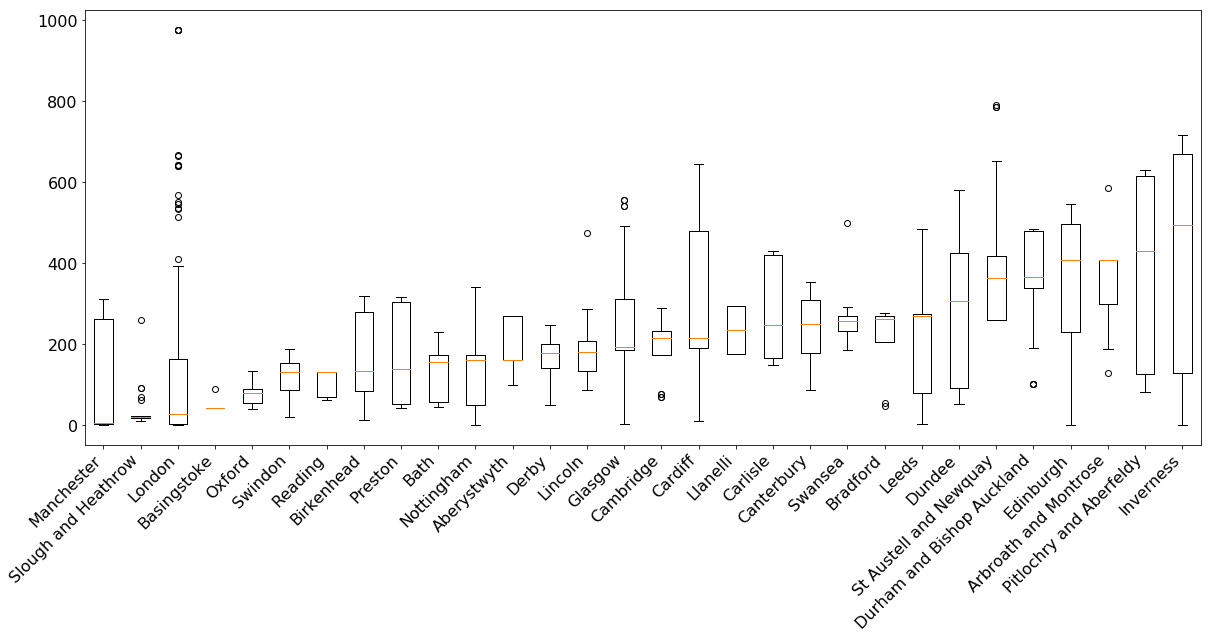

In [112]:
# Prepare data for plotting (sort by median distance)
data_for_boxplot = [(k,v) for k,v in data.items() if len(v) > 5]
data_for_boxplot = sorted(data_for_boxplot,key=lambda x : np.median(x[1]))
labels = [id_name_mapping[k] for k,v in data_for_boxplot]
data_for_boxplot = [v for k,v in data_for_boxplot]
# Plot
fig, ax = plt.subplots(figsize=(20,8))
result = ax.boxplot(data_for_boxplot,labels=labels)
plt.xticks(rotation=45,ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

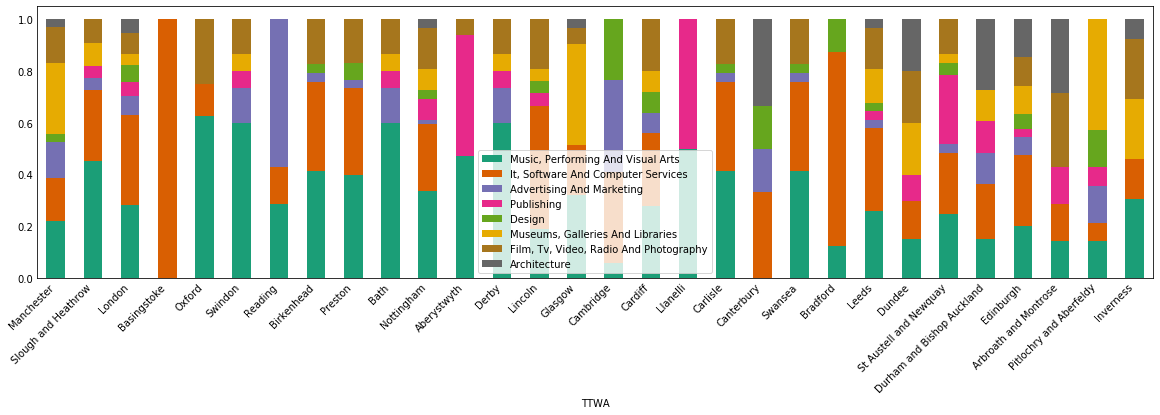

In [57]:
data_for_stackplot = [(k,v) for k,v in ttwa_cats.items() if sum(v.values()) > 5]
data_for_stackplot = sorted(data_for_stackplot,key=lambda x : np.median(data[x[0]]))
_data_for_stackplot = []
for _id,ce_counts in data_for_stackplot:
    for ce, count in ce_counts.items():
        for i in range(0,count):
            _data_for_stackplot.append(dict(TTWA=id_name_mapping[_id],Sector=ce))

distance_df = pd.DataFrame([np.median(x) for x in data_for_boxplot],index=labels,columns=["distance"])
ce_df = []
for ttwa,_df in pd.DataFrame(_data_for_stackplot).groupby("TTWA"):
    _ce_data = {s:len(__df)/len(_df) for s,__df in _df.groupby("Sector")}
    _ce_data["TTWA"] = ttwa
    ce_df.append(_ce_data)
    
ce_df = pd.DataFrame(ce_df)
comb_df = ce_df.join(distance_df,on="TTWA").set_index("TTWA")
y_order = [x for x in comb_df.corr()["distance"].sort_values().index if x is not "distance"]

fig, ax = plt.subplots(figsize=(20,5))
pp.stack(pd.DataFrame(_data_for_stackplot), x="TTWA", y="Sector", fractions=True, 
         ax=ax, x_order=labels, cmap_name="Dark2", y_order=y_order)
plt.xticks(rotation=45,ha='right')

In [15]:
set(x["Sector"] for x in _data_for_stackplot)

{'Advertising and marketing',
 'Architecture',
 'Design',
 'Film, TV, video, radio and photography',
 'IT, software and computer services',
 'Museums, galleries and libraries',
 'Music, performing and visual arts',
 'Publishing'}

Text(0,0.5,'Distance from university\nto collaborating company')

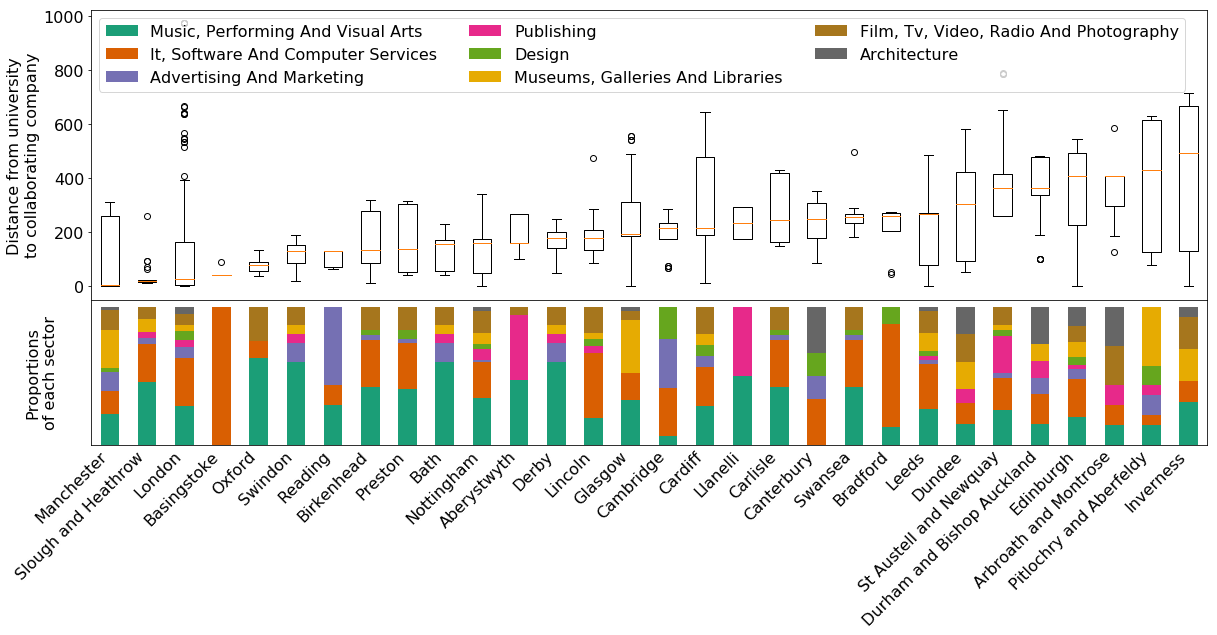

In [110]:
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(20,8))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

data_for_boxplot = [(k,v) for k,v in data.items() if len(v) > 5]
data_for_boxplot = sorted(data_for_boxplot,key=lambda x : np.median(x[1]))
labels = [id_name_mapping[k] for k,v in data_for_boxplot]
data_for_boxplot = [v for k,v in data_for_boxplot]
#fig, ax = plt.subplots(figsize=(20,8))
result = ax1.boxplot(data_for_boxplot,labels=None)
plt.xticks(rotation=45,ha='right')

data_for_stackplot = [(k,v) for k,v in ttwa_cats.items() if sum(v.values()) > 5]
data_for_stackplot = sorted(data_for_stackplot,key=lambda x : np.median(data[x[0]]))
_data_for_stackplot = []
for _id,ce_counts in data_for_stackplot:
    for ce, count in ce_counts.items():
        for i in range(0,count):
            _data_for_stackplot.append(dict(TTWA=id_name_mapping[_id],Sector=ce))

distance_df = pd.DataFrame([np.median(x) for x in data_for_boxplot],index=labels,columns=["distance"])
ce_df = []
for ttwa,_df in pd.DataFrame(_data_for_stackplot).groupby("TTWA"):
    _ce_data = {s:len(__df)/len(_df) for s,__df in _df.groupby("Sector")}
    _ce_data["TTWA"] = ttwa
    ce_df.append(_ce_data)
    
ce_df = pd.DataFrame(ce_df)
comb_df = ce_df.join(distance_df,on="TTWA").set_index("TTWA")
y_order = [x for x in comb_df.corr()["distance"].sort_values().index if x is not "distance"]

# fig, ax = plt.subplots(figsize=(20,5))
pp.stack(pd.DataFrame(_data_for_stackplot), x="TTWA", y="Sector", fractions=True, 
         ax=ax2, x_order=labels, cmap_name="Dark2", y_order=y_order)
plt.xticks(rotation=45,ha='right',fontsize=16)
ax2.yaxis.set_ticklabels([])

handles, labels = ax2.get_legend_handles_labels()
ax1.legend(handles, labels, loc=2, ncol=3)
ax2.legend_.remove()
ax2.set_ylabel("Proportions\nof each sector",labelpad=30)
ax2.set_xlabel("")
ax1.set_ylabel("Distance from university\nto collaborating company")


[]